In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

np.random.seed(2131)

import warnings
warnings.filterwarnings('ignore')

%run ../src/elo.py
%run ../src/elo_game_by_game.py

In [2]:
# load files ( DATA )

teams               = pd.read_csv('../data/Teams.csv')
seasons             = pd.read_csv('../data/Seasons.csv')
reg_season_compact  = pd.read_csv('../data/RegularSeasonCompactResults.csv')
reg_season_detailed = pd.read_csv('../data/RegularSeasonDetailedResults.csv')
tourney_compact     = pd.read_csv('../data/TourneyCompactResults.csv')
tourney_detailed    = pd.read_csv('../data/TourneyDetailedResults.csv')
tourney_seeds       = pd.read_csv('../data/TourneySeeds.csv')
tourney_slots       = pd.read_csv('../data/TourneySlots.csv')

** Notes **

- NCAA is a college level baseketball tournament.
- NCAA is a single-elimination tournament.
- Features 68 teams.
- 32 teams consist of divison 1 conferences and reserve the right to be invited.
- other 36 teams are chosen by the NCAA officials.
- Announcement of these 36 teams is televised event and done a week before the FIRST-FOUR and called
  __Selection Sunday__
- 68 teams are divided into four regions and organized into single elimination bracket, which predetermines when a team wins, which team it will face next.
- Each team is ranked or seeded within a region from 1 to 16.
- After intial round of matches between 8 lower ranked teams, tournaments continues for next 3 weekends .
- First round consist of 64 teams which lead to a __Sweet Sixteen__

** Task **

<u>What to predict</u>

Stage 1 - You should submit predicted probabilities for every possible matchup in the past 4 NCAA tournaments (2013-2016).

** Data Description **

- Files given to us in the beginning are _essential files_.
- Optional data files may be added in the system.
- You can assume that essential files might be provided for current season.
- You can not assume that optional data files will be provided for current season.


<u>Seasons</u>

- Identifies different seasons included in the historical data
    - "season": indicates the year in which the tournament was played.
    - "dayzero": tells you the date corresponding to daynum = 0 during that season.
    - Championship game is always played on daynum = 154, National Semifinals on daynum = 152, playin games on daynum = 134/135, Selection Sunday = 132
    - "region": four regions in the final tournament W/X/Y/Z

<u> Regular Season Compact Results </u>
- Game by Game results of all games played upto daynum = 132 for all the 32 seasons from 1985 to 2015. Each row represents single game played.

    - "season": the year in which the final tournament occurs.
    - "daynum": integer that represents the offset from dayzero between 0 and 132. No team played more than 1 match on any given day.
    - "wteam": id of the winning team.
    - "wscore": number of points scored by the winning team.
    - "lteam": id of the losing team.
    - "lscore": number of points scored by the losing team.
    - "numot": number of overtime periods in the game >=0
    - "wloc":  id of the location of winning team. ( H, A, N )

<u> Regular Season Detailed Results </u>
- More detailed information game by game for seasons 2003-2016. Include game level statistics for each game.

<u> Tourney Compact Results </u>
- Game by Game data for all seasons of historical data. These also include play-in games when there were one.

<u> Tourney Compact Detailed Results </u>
- More detailed information game by game 2003 onwards

<u> Tourney Seeds </u>
- "season" : year
- "seed"   : 'Region[0-9][0-9][a/b]' Structure of the seed first alphabet represents the region, next two represents the seed in that region and fourth character is for those teams that played in play in
- "team"   : team identifier

<u> Tourney Slots </u>
- "season"     : year.
- "slot"       : uniquely determines of the tournament games.
- "strongseed" : expected seed of the stronger team that plays in this game.
- "weakerseed" : expected seed of the weaker team that plays in this game.

In [9]:
teams.head()

,Team_Id,Team_Name
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [21]:
print('Total number of teams ', len(teams))
print('Total unique teams ', teams.Team_Id.nunique())

Total number of teams  364
Total unique teams  364


In [13]:
seasons.head()

,Season,Dayzero,Regionw,Regionx,Regiony,Regionz
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


In [22]:
print('Total number of seasons recorded ', len(seasons))
print('Total number of unique seasons recorded ', seasons.Season.nunique())

Total number of seasons recorded  33
Total number of unique seasons recorded  33


In [23]:
reg_season_compact.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


** ELO Rating Scheme **

ELO Rating scheme assumes that the performance of a team is normally distributed. We will gauge performance based on the score of the team.

In [83]:
def get_team_performance(reg_season_compact, team_id):
    winning_mask = reg_season_compact.Wteam == team_id
    losing_mask  = reg_season_compact.Lteam == team_id
    
    return reg_season_compact.loc[winning_mask, 'Wscore'].tolist() + \
           reg_season_compact.loc[losing_mask, 'Lscore'].tolist()

In [90]:
def plot_point_distribution(team_perf, team_id):
    sns.distplot(team_perf)
    plt.title('Points scored by team:%d'%(team_id))
    plt.xlabel('Points scored');

In [92]:
reg_season_compact.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


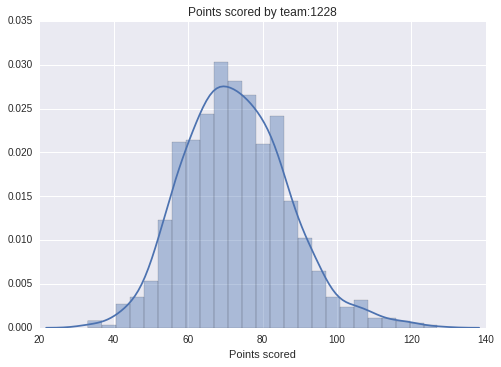

In [91]:
team_perf = get_team_performance(reg_season_compact, 1228)
plot_point_distribution(team_perf, 1228)

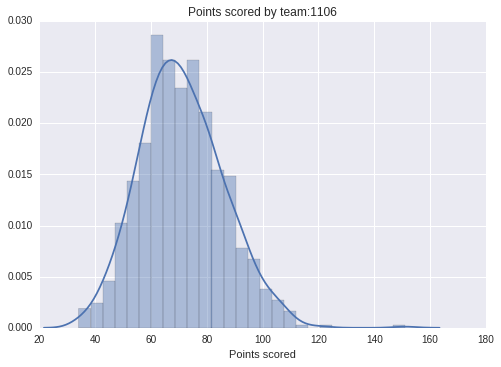

In [93]:
team_perf = get_team_performance(reg_season_compact, 1106)
plot_point_distribution(team_perf, 1106)

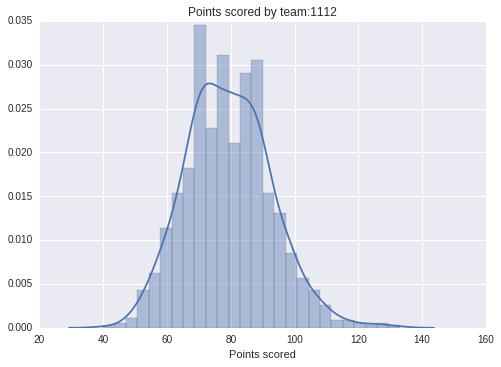

In [94]:
team_perf = get_team_performance(reg_season_compact, 1112)
plot_point_distribution(team_perf, 1112)

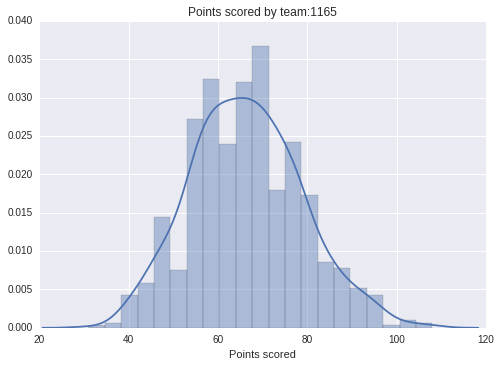

In [95]:
team_perf = get_team_performance(reg_season_compact, 1165)
plot_point_distribution(team_perf, 1165)

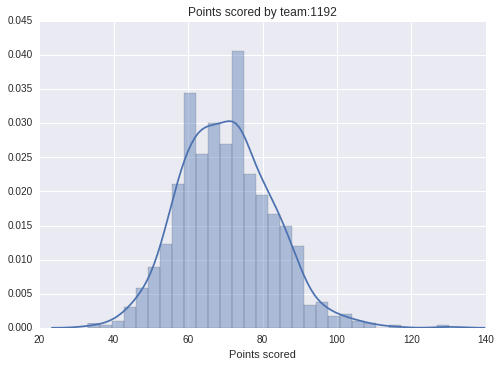

In [96]:
team_perf = get_team_performance(reg_season_compact, 1192)
plot_point_distribution(team_perf, 1192)

** Performances are more or less normally distributed. **

In [3]:
def get_all_teams(reg_season_compact):
    reg_season_shape = len(reg_season_compact)
    reg_season_1D    = reg_season_compact[['Wteam', 'Lteam']].values\
                           .reshape(reg_season_shape * 2, 1).squeeze()

    all_teams = np.unique(reg_season_1D)
    return all_teams

In [4]:
all_teams = get_all_teams(reg_season_compact)
ratings = {team: 1300 for team in all_teams}

In [312]:
for i in range(5):
    row = reg_season_compact.iloc[i,2:7]
    Wteam = row.Wteam
    Lteam = row.Lteam
    Wscore = row.Wscore
    Lscore = row.Lscore
    score_diff = Wscore - Lscore
    
    mov_multiplier_wteam = ((score_diff + 3) ** 0.8) / \
                           (7.5 + .006*(ratings[Wteam] - ratings[Lteam]))
    print('score diff ', score_diff)
#     mov_multiplier_wteam = np.log(score_diff + 1) * \
#                            (2.2/((ratings[Wteam] - ratings[Lteam])*.001+2.2))
    
    expected_score_wteam = Season.expected(ratings[Wteam], ratings[Lteam])
    expected_score_lteam = Season.expected(ratings[Lteam], ratings[Wteam])
    
    actual_score_Wteam   = 1
    actual_score_Lteam   = 0
    
    print('expected scrore wteam ', expected_score_wteam)
    print('expected scrore lteam ', expected_score_lteam)
    
    print('Mov multiplier wteam ', mov_multiplier_wteam)
                                                         
    print('Winning team elo score original ', ratings[Wteam])
    print(ratings[Wteam] + 20 * (actual_score_Wteam - expected_score_wteam))
    print('Losing team elo score', ratings[Lteam])
    print(ratings[Lteam] + 20 * (actual_score_Lteam - expected_score_lteam))

    print('-'*75)

score diff  17
expected scrore wteam  0.5
expected scrore lteam  0.5
Mov multiplier wteam  1.46474739107
Winning team elo score original  1300
1310.0
Losing team elo score 1300
1290.0
---------------------------------------------------------------------------
score diff  7
expected scrore wteam  0.5
expected scrore lteam  0.5
Mov multiplier wteam  0.841276459307
Winning team elo score original  1300
1310.0
Losing team elo score 1300
1290.0
---------------------------------------------------------------------------
score diff  7
expected scrore wteam  0.5
expected scrore lteam  0.5
Mov multiplier wteam  0.841276459307
Winning team elo score original  1300
1310.0
Losing team elo score 1300
1290.0
---------------------------------------------------------------------------
score diff  16
expected scrore wteam  0.5
expected scrore lteam  0.5
Mov multiplier wteam  1.4058585205
Winning team elo score original  1300
1310.0
Losing team elo score 1300
1290.0
-------------------------------------

In [5]:
def rate_game_by_game(season_list, ratings):
    for season in season_list:
        ratings = rate_team_for_season(reg_season_compact.loc[reg_season_compact.Season == season], ratings)
        
    return ratings

In [6]:
elo_ratings = rate_game_by_game(np.arange(1985, 2013, 1), ratings)

In [279]:
def calculate_elo_ratings(reg_season_compact, season_list):
    
    # initialize ratings
    ratings = {team: 1300 for team in all_teams}
    
    for season in season_list:
        season_perf   = reg_season_compact.loc[reg_season_compact.Season == season]
        season        = Season(season_perf)
        teams         = season.get_teams_in_season()
        opponents     = season.get_opponents_list()
        actual_perf   = season.get_actual_performance(opponents)
        expected_perf = season.get_expected(ratings, opponents)
        ratings       = season.update_ratings(ratings)
    
    return ratings

In [284]:
elo_ratings = calculate_elo_ratings(reg_season_compact, 
                                    np.arange(1985, 2013, 1))

In [7]:
# Create Submission
sub = pd.read_csv('../data/sample_submission.csv')

In [8]:
def predict(sub, elo_ratings):
    predictions = []
    
    for id_, pred in zip(sub['id'], sub['pred']):
        season, team_1, team_2 = id_.split('_')
        team_1 = int(team_1)
        team_2 = int(team_2)
        
        if team_1 < team_2:
            predictions.append(Season.expected(elo_ratings[team_1],
                                               elo_ratings[team_2]))
        else:
            predictions.append(Season.expected(elo_ratings[team_2],
                                               elo_ratings[team_1]))
    
    return predictions

In [9]:
predictions = predict(sub, elo_ratings)

In [10]:
sub['pred'] = predictions
sub.to_csv('../submissions/new_elo_without_mov.csv', index=False)

In [12]:
sub.shape

(9112, 2)